# Домашняя работа №3

# Преамбула

Автоэнкодеры - это полносвязные сети, задачей которых является на выходе сети восстановить объекты, поданные на вход. Такие сети состоят из двух частей - енкодера и декодера. В каждом следующем слое энкодера становится всё меньше и меньше нейронов, в результате чего происходит "сжатие" исходной информации. В самом сжатом виде информация находится на последнем слое энкодера который называется bottleneck(с англ. бутылочное горлышко). Далее информация из bottleneck'a подаётся на вход декодеру, у которого наоборот с каждый следующим слоем количество нейронов становится больше и больше. Размерности выходов и входов такой нейронной сети совпадают. 

<img src="autoencoder.png">

Активации нейронов с самого узкого слоя можно использовать как довольно качественные признаки для передачи в другие модели машинного обучения.

Целью данного домашнего задания является реализация нескольких вариантов автокодировщиков, проведение экспериментов с целью определения структур, которые выучивают нейроны. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (9,5)
plt.rc('font', family='Arial')
plt.style.use('ggplot')

In [2]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

# Загрузка и предобработка данных(2.5 балла).

In [3]:
from functools import reduce
from collections import Callable, Collection

> Функции для вывода изображений из массива изображений.

In [4]:
def plot_img(image: np.ndarray,
             title: object,
             shape: tuple, 
             bw: bool, 
             side_size: int,
             **kwargs) -> None:
    """ Print given image on specified subplot position. """
    _ = plt.subplot(shape[0], shape[1], shape[2])
    _ = plt.grid()
    
    if bw:
        _ = plt.imshow(image.reshape(side_size, -1), **kwargs)
    else:
        _ = plt.imshow(image.reshape(side_size, side_size, -1), **kwargs)

    if title is not None:
        _ = plt.title(title)

def plot_images_array(images: Collection, 
                      titles: Collection=None, 
                      shape: tuple=(3, 5), 
                      bw: bool=False, 
                      side_size: int=None, 
                      **kwargs) -> None:
    """ Print some images from given array. """
    if side_size is None: 
        side_size = images.shape[1]
        
    for idx in range(int(reduce(np.multiply, shape))):
        plot_img(images[idx], None if titles is None else titles[idx], 
                 (shape[0], shape[1], idx + 1), bw, side_size, **kwargs)

Загрузите *images.pkl*. Данный файл содержит набор фото. 

In [5]:
%%time

images = np.load(open('images.npy', 'br'))
print(images.shape)

(7000, 120, 120, 3)
Wall time: 4.84 s


In [6]:
plot_images_array(images, shape=(2, 5), interpolation="none")

## Генерация датасета(2 балла)

Напишите функцию, которая принимает на вход исходный набор фотографий из возращает нужное количество "сэмплов" - случайных квадратных подкартинок нужного размера. Визуализируйте несколько сэмплов.

> Вероятно, не самое оптимальное решение, однако выполняется приемлемо быстро.

In [7]:
def get_samples(full_images: Collection, 
                num_samples: int=10000, 
                sample_size: int=16) -> np.ndarray:
    """ Get random images' subsets from images array. """
    original_size = np.min(full_images.shape[1:3])
    if original_size <= sample_size:
        raise ValueError(f"Wrong sample size {sample_size}")
    
    res = []
    for _ in range(num_samples):
        # get random image from dataset
        img_num = np.random.choice(original_size)  
        # get random indexes for top left coropped frame corner
        top_left = (np.random.choice(original_size-sample_size), 
                    np.random.choice(original_size-sample_size))  
        # create "frame" to crop
        frame = ((top_left[0], top_left[0] + sample_size), 
                (top_left[1], top_left[1] + sample_size))
        # choose correct pixels subset from random image from database
        res.append(full_images[img_num, frame[0][0]:frame[0][1], 
                               frame[1][0]:frame[1][1], :])
        del img_num, top_left, frame
    return np.array(res) 

In [8]:
%%time

samples = get_samples(images)

Wall time: 261 ms


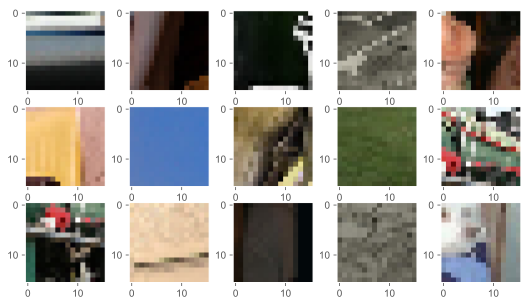

In [9]:
plot_images_array(samples)

## Нормировка картинок и вытягивание их в один вектор(0.5 балл)

> Удобнее будет сначала преобразовать каждый объект выборки в вектор, а зетем нормировать.

Преобразуйте каждый семпл-матрицу в вектор.

То есть из исходного набора сэмплов размера [num_samples, sample_size, sample_size, 3] должен получиться набор размера [num_samples, sample_size x sample_size x 3].

In [10]:
samples = samples.reshape(samples.shape[0], -1)
samples.shape

(10000, 768)

Переведите интенсивности каждого канала (R, G, B) в отрезок $[0.1, 0.9]$. Значения отбрасывать не надо, просто отшкалируйте каналы.

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
samples = MinMaxScaler((0.1, 0.9)).fit_transform(samples)
print(f"min: {np.min(samples)}, max: {np.max(samples)}, shape: {samples.shape}")

min: 0.1, max: 0.9, shape: (10000, 768)


# Реализация и обучение автокодировщика(4 балла)

### Построение автокодировщика(1.5 балла)

Напишите функцию, которая принимает параметры автокодировщика(размер входа и выхода, количества нейронов в каждом слое энкодера, количество нейронов в каждом слое декодера). Внутри автокодировщика использовать нелинейности-RELU. Но для выходов автоэнкодера использовать сигмоиду.

Выход функции - Keras модель, скомпилированная чтобы минимизировать MSE на трэйне. Оптимизатор - на ваш выбор.

In [13]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer

Using TensorFlow backend.


In [14]:
def create_autoencoder_model(object_size: int, 
                             encoder_layer_shapes: Collection=(256, 144, 64), 
                             decoder_layer_shapes: Collection=(200, 400),
                             loss: str='mean_squared_error',
                             optimizer: str='adam') -> object:
    """ Creates autoencoder model with given params. """
    encoder_layer_shapes = list(encoder_layer_shapes)
    encoder_layer_shapes.extend(decoder_layer_shapes)

    model = Sequential(layers=[InputLayer((object_size,)), 
                               *[Dense(shape, activation="relu") 
                                 for shape in encoder_layer_shapes]])
    model.add(Dense(object_size, activation="sigmoid"))
    
    model.compile(loss=loss, optimizer=optimizer)

    return model

Разделите выборку из сэмплов на тренировочную выборку и валидационную отношении 90%-10%.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [16]:
train, test = train_test_split(samples, test_size=0.1, random_state=RANDOM_SEED)
print(train.shape, test.shape)

(9000, 768) (1000, 768)


Обучите модель со стандартными параметрами.

> Параметры модели (при создании: число и размер слоев энкодера, декодера) стандартные. При обучении немного увеличено число эпох обучения и отключен подробный вывод прогресса обучения для экономии пространства.

> Итоговый score модели приведен ниже.

In [17]:
%%time

model = create_autoencoder_model(train.shape[1])
model.summary()

model.fit(train, train, verbose=0, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               196864    
_________________________________________________________________
dense_2 (Dense)              (None, 144)               37008     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                9280      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               13000     
_________________________________________________________________
dense_5 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 768)               307968    
Total para

In [18]:
%%time

pred_train = model.predict(train)
print(f"train MSE: {MSE(train, pred_train)}")

pred_test = model.predict(test)
print(f"test MSE: {MSE(test, pred_test)}")

train MSE: 0.0055302632418445935
test MSE: 0.006158806684485922
Wall time: 996 ms


### Визуализация паттернов, которые находят нейроны(1.5 балла)

Возьмите несколько объектов из валидационной выборки и прогоните через автоэнкодер. Оцените визуально результат восстановления объектов.

In [19]:
def plot_real_pred_images(real: Collection, 
                          predicted: Collection, 
                          shape: int=5, 
                          bw: bool=False, 
                          side_size: int=16,
                          scorer: Callable=MSE,
                          **kwargs) -> None:
    """ Display real image alongside with predicted with autoencoder. """
    for idx in range(shape):
        plot_img(real[idx], None, (2, shape, idx + 1), bw, side_size, **kwargs)
        plot_img(predicted[idx], None, (2, shape, idx + shape + 1), bw, side_size, **kwargs)
        _ = plt.title(f"{scorer(real[idx], predicted[idx]):.5}")

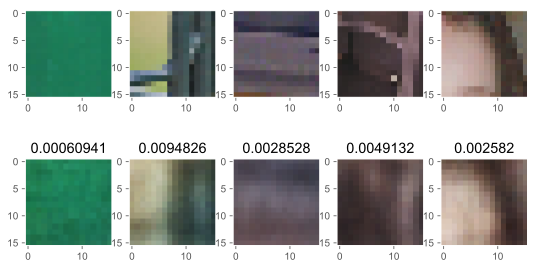

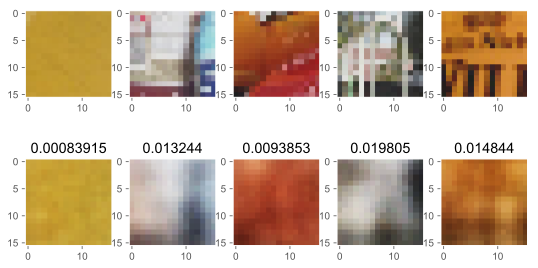

In [20]:
plot_real_pred_images(train, pred_train)
_ = plt.show()
plot_real_pred_images(test, pred_test)

> Очертания исходного изображения различимы, однако достаточно сильно деформированы.

Для каждого слоя и для каждого нейрона на этом слое найдите объект из тренировочной выборки, на котором этот нейрон выдаёт наибольшую активацию. Если нейрон ни на одном объекте не активировался, пропустите изображение для него. Что можете сказать про сложность шаблонов на объектах для каждого слоя?

In [21]:
from keras.activations import relu, sigmoid
import tensorflow as tf

> Имеется модель следующего вида:

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               196864    
_________________________________________________________________
dense_2 (Dense)              (None, 144)               37008     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                9280      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               13000     
_________________________________________________________________
dense_5 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 768)               307968    
Total para

> Получение весов модели. Каждое второе значение - веса при свободном члене (bias).

In [23]:
weights = model.get_weights()

for n, weight in enumerate(weights):
    print(f"{n}\t{weight.shape}")

0	(768, 256)
1	(256,)
2	(256, 144)
3	(144,)
4	(144, 64)
5	(64,)
6	(64, 200)
7	(200,)
8	(200, 400)
9	(400,)
10	(400, 768)
11	(768,)


> Подсчет активаций нейронов первого слоя для одного изображения.

In [24]:
%%time

sample = samples[0]
l0_weight = weights[0]
l0_bias = weights[1]

l0_activations = relu(np.dot(sample, l0_weight) + l0_bias)

with tf.Session().as_default():
    print(l0_activations.eval())

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          2.94154357
  0.          3.65279531  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.75016751  0.          1.56361295  1.4102502   0.
  2.09802378  0.          0.          0.          0.          0.          0.
  0.          0.63881296  0.          0.          0.          0.          0.
  3.99563827  1.67355064  0.          0.          0.          2.1838223   0.
  0.          3.88995006  0.          2.39754418  0.          1.65790157
  0.          0.          0.          3.31938392  3.57210786  0.          0.
  0.          4.07853547  3.71760346  0.          2.23999172  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          3.17158926
  2.98276544  0.       

> Полученный резултат - разреженная матрица, вероятно, демонстрирует не очень высокую сложность шиблонов на объектах каждого слоя (предположение 1). 

> Функция для определения активаций одного слоя нейронов.

In [25]:
def find_max_activation_for_layer(samples: np.ndarray, 
                                  weights: np.ndarray, 
                                  bias: np.ndarray,
                                  activation: Callable, 
                                  session: object=None) -> np.ndarray:
    max_activations = np.zeros(weights.shape[-1])
    indexes = np.zeros(weights.shape[-1])
    if session is None:
        session = tf.Session()
            
    for idx, sample in enumerate(samples):
        with session.as_default():
            activations = activation(np.dot(sample, weights) + bias).eval()
        
        for jdx in range(weights.shape[-1]):
            if activations[jdx] > max_activations[jdx]:
                max_activations[jdx] = activations[jdx]
                indexes[jdx] = idx + 1
    
    return indexes, max_activations

> Просмотр активаций нейронов первого слоя.

In [26]:
%%time

indexes, max_activations = find_max_activation_for_layer(
    samples, weights[0], weights[1], relu)

Wall time: 31min 22s


> Просмотр количества активированных нейронов первого слоя в целом и количества уникальных активированных нейронов.

In [27]:
print(indexes.nonzero()[0].shape, np.unique(indexes).shape)

(87,) (72,)


> Можно сделать вывод, что большая часть нейронов первого слоя остается не активированной, а активации происходят только на небольшом количестве изображений (подтверждение предположения 1).

> Функция для определения активаций нейронов всех слоев.

In [28]:
def find_max_activations(samples: np.ndarray,
                         weights: np.ndarray,
                         session: object=None) -> np.ndarray:
    if session is None:
        session = tf.Session()
        
    max_activations = [np.zeros(b.shape) for i, b in enumerate(weights) if i % 2]
    indexes = [np.zeros(b.shape) for i, b in enumerate(weights) if i % 2]
    
    _weights = [w for i, w in enumerate(weights) if not i % 2]
    _biases = [b for i, b in enumerate(weights) if i % 2]
            
    for idx, sample in enumerate(samples):
        _activation = relu
        
        activations = []
        with session.as_default():
            activations.append(_activation(np.dot(sample, _weights[0]) + _biases[0]).eval())
        
        for jdx, (weight, bias) in enumerate(zip(_weights[1:], _biases[1:])):
            if jdx == len(_weights) - 2:
                _activation = sigmoid
            with session.as_default():
                activations.append(_activation(np.dot(activations[jdx], weight) + bias).eval())
            
        for jdx, layer in enumerate(activations):
            for kdx, activation in enumerate(layer):
                if activation > max_activations[jdx][kdx]:
                    max_activations[jdx][kdx] = activation
                    indexes[jdx][kdx] = idx + 1  # to exclude 0
                    
    return indexes, max_activations

> Тестирование функции для 1 изображения.

In [29]:
%%time
# %pdb

full_indexes, full_max_activations = find_max_activations((samples[0],), weights)

Wall time: 6.71 s


In [30]:
for index in full_indexes:
    print(index.nonzero()[0].shape, np.unique(index).shape)

(75,) (2,)
(58,) (2,)
(28,) (2,)
(143,) (2,)
(217,) (2,)
(768,) (1,)


> Видно, что функция работает корректно. Из полученных результатов также можно сделать предположение (2) о шаблонах модели: сложность шаблона растет с продвижением вглубь (от входов к выходам) модели, достигая предела (в отношении числа активаций к общему числу нейронов) в bottleneck'e (место, где менье всего нейронов, следовательно, ниже вероятность, что найдутся нейроны, на которые не повлияло исходное изображение).

> *Из-за ограничений вычислительных мощностей, функция подсчитана для ограниченной выборки из исходного набора изображений.*

In [31]:
%%time

full_indexes, full_max_activations = find_max_activations(samples[:1000], weights)

Wall time: 40min 29s


In [73]:
for idx, index in enumerate(full_indexes):
    nonzero = index.nonzero()[0].shape
    unique = np.unique(index).shape
    full_len = len(weights[1::2][idx])
    
    print(f"{nonzero} - {100*nonzero[0]/full_len:.3}%", 
          f"{unique} - {100*unique[0]/full_len:.3}")

(83,) - 32.4% (41,) - 16.0
(61,) - 42.4% (40,) - 27.8
(35,) - 54.7% (28,) - 43.8
(180,) - 90.0% (72,) - 36.0
(307,) - 76.8% (90,) - 22.5
(768,) - 1e+02% (60,) - 7.81


> Из полученных результатов видно, что предположение 2 не совсем верно: сложность шаблонов действительно растет по мере продвижения вглубь модели, однако не достигает своего максимума в bottleneck'e. В bottleneck'e достигает максимума процентное соотношение числа уникальных нейронов, вносящих свое влияние в модель к общему числу нейронов. 

> В общем случае, лишь небольшое число нейронов энкодера принимает участие в шифровании исходного изображения, большая же часть нейронов декодера задействована.

### Исследование зависимости качества восстановления от параметров автоэнкодера (1 балл)


Обучите несколько автоэнкодеров с различным количеством слоёв, разными размерами bottleneck'a и сравните, насколько быстро модели обучаются и финальный лосс на валидационной выборке. Какие выводы вы можете сделать?

> Функция для анализа временных затрат на выполнение определенного действия.

In [33]:
from time import time

In [34]:
def time_benchmark(target: Callable, name: str, *args, **kwargs) -> object:
    """ Prints time assumption for target execution. """
    start_t = time()
    res = target(*args, **kwargs)
    print(f"{name} time: {time() - start_t} sec.")
    return res

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                38450     
_________________________________________________________________
dense_8 (Dense)              (None, 768)               39168     
Total params: 77,618
Trainable params: 77,618
Non-trainable params: 0
_________________________________________________________________
fit time: 37.40706753730774 sec.
predict train time: 0.7991750240325928 sec.
predict test time: 0.04687809944152832 sec.
train MSE: 0.0074924708431224896
test MSE: 0.007918915521330032


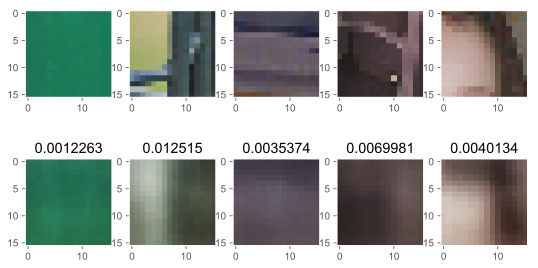

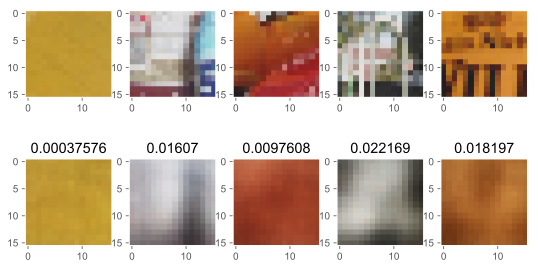

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               98432     
_________________________________________________________________
dense_10 (Dense)             (None, 768)               99072     
Total params: 197,504
Trainable params: 197,504
Non-trainable params: 0
_________________________________________________________________
fit time: 55.53639626502991 sec.
predict train time: 1.1704351902008057 sec.
predict test time: 0.04687833786010742 sec.
train MSE: 0.00521132757197595
test MSE: 0.0056211675582680835


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               196864    
_________________________________________________________________
dense_12 (Dense)             (None, 768)               197376    
Total params: 394,240
Trainable params: 394,240
Non-trainable params: 0
_________________________________________________________________
fit time: 84.80619716644287 sec.
predict train time: 1.2346704006195068 sec.
predict test time: 0.07813262939453125 sec.
train MSE: 0.003748391865850244
test MSE: 0.004141262364345358


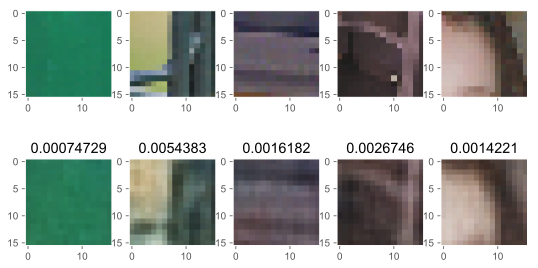

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 600)               461400    
_________________________________________________________________
dense_14 (Dense)             (None, 768)               461568    
Total params: 922,968
Trainable params: 922,968
Non-trainable params: 0
_________________________________________________________________
fit time: 212.7338309288025 sec.
predict train time: 1.5243113040924072 sec.
predict test time: 0.1250159740447998 sec.
train MSE: 0.002615820125356988
test MSE: 0.0029580655850320694


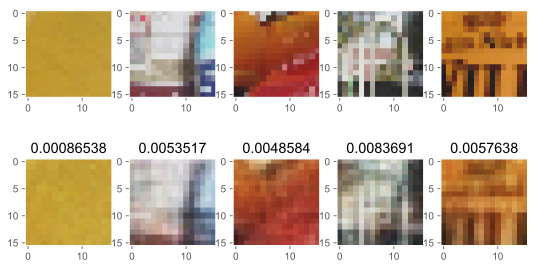

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 450)               346050    
_________________________________________________________________
dense_16 (Dense)             (None, 768)               346368    
Total params: 692,418
Trainable params: 692,418
Non-trainable params: 0
_________________________________________________________________
fit time: 163.38227462768555 sec.
predict train time: 1.3485829830169678 sec.
predict test time: 0.07813286781311035 sec.
train MSE: 0.0025469480062200265
test MSE: 0.0028933475246488796


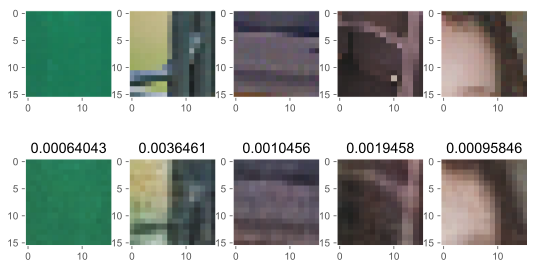

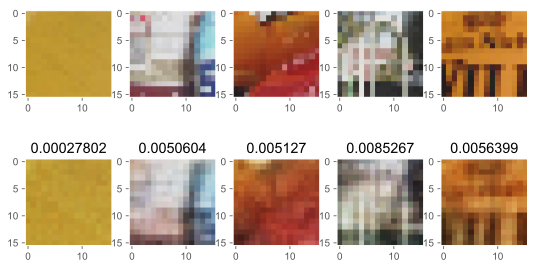

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 600)               461400    
_________________________________________________________________
dense_18 (Dense)             (None, 450)               270450    
_________________________________________________________________
dense_19 (Dense)             (None, 768)               346368    
Total params: 1,078,218
Trainable params: 1,078,218
Non-trainable params: 0
_________________________________________________________________
fit time: 239.50114250183105 sec.
predict train time: 1.6812994480133057 sec.
predict test time: 0.14064240455627441 sec.
train MSE: 0.002385643256374948
test MSE: 0.0028066403408528785


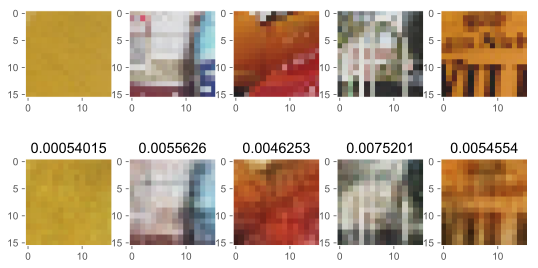

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 450)               346050    
_________________________________________________________________
dense_21 (Dense)             (None, 600)               270600    
_________________________________________________________________
dense_22 (Dense)             (None, 768)               461568    
Total params: 1,078,218
Trainable params: 1,078,218
Non-trainable params: 0
_________________________________________________________________
fit time: 245.04694747924805 sec.
predict train time: 1.9475383758544922 sec.
predict test time: 0.1406412124633789 sec.
train MSE: 0.002521973084539523
test MSE: 0.0029440134591273612


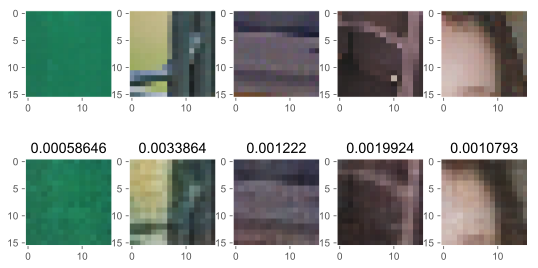

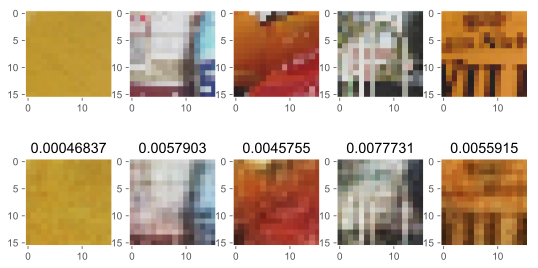

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 600)               461400    
_________________________________________________________________
dense_24 (Dense)             (None, 450)               270450    
_________________________________________________________________
dense_25 (Dense)             (None, 600)               270600    
_________________________________________________________________
dense_26 (Dense)             (None, 768)               461568    
Total params: 1,464,018
Trainable params: 1,464,018
Non-trainable params: 0
_________________________________________________________________
fit time: 324.67303562164307 sec.
predict train time: 2.073011875152588 sec.
predict test time: 0.17189455032348633 sec.
train MSE: 

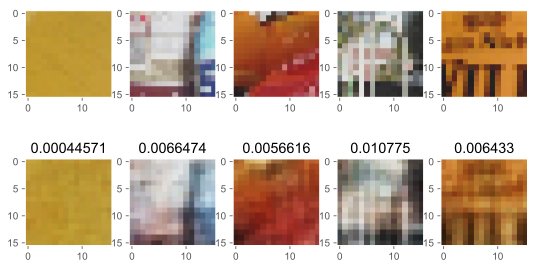

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 768)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 600)               461400    
_________________________________________________________________
dense_28 (Dense)             (None, 500)               300500    
_________________________________________________________________
dense_29 (Dense)             (None, 450)               225450    
_________________________________________________________________
dense_30 (Dense)             (None, 500)               225500    
_________________________________________________________________
dense_31 (Dense)             (None, 600)               300600    
_________________________________________________________________
dense_32 (Dense)             (None, 768)               461568    
Total para

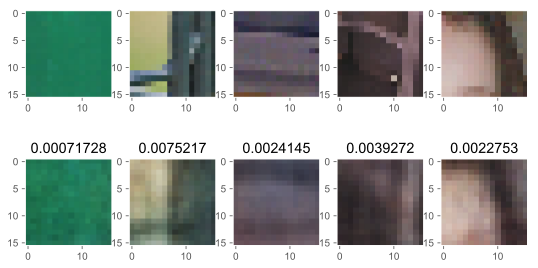

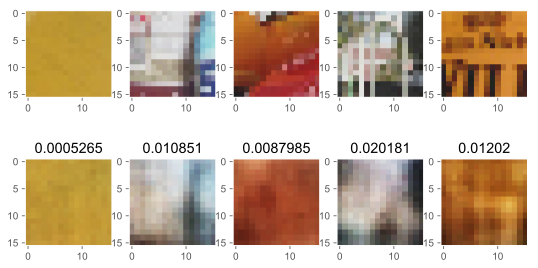

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 768)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 600)               461400    
_________________________________________________________________
dense_34 (Dense)             (None, 550)               330550    
_________________________________________________________________
dense_35 (Dense)             (None, 500)               275500    
_________________________________________________________________
dense_36 (Dense)             (None, 450)               225450    
_________________________________________________________________
dense_37 (Dense)             (None, 500)               225500    
_________________________________________________________________
dense_38 (Dense)             (None, 550)               275550    
__________

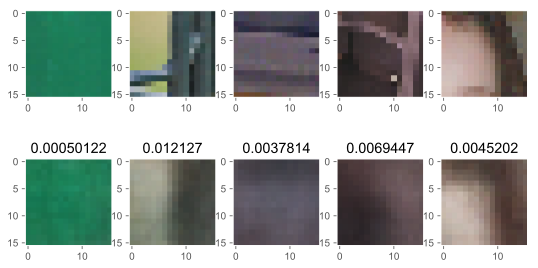

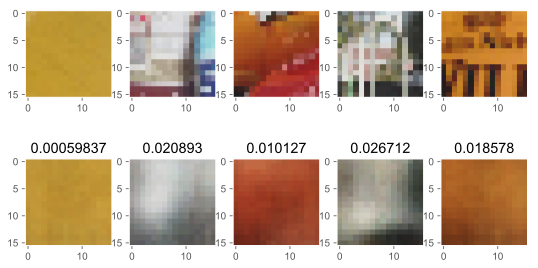

Wall time: 39min 18s


In [35]:
%%time

ENC = "encoder_layer_shapes"
DEC = "decoder_layer_shapes"

fixtures = (
    # исследование влияния ширины bottleneck'a (при фиксированном числе слоев)
    {ENC: [50], DEC: []},  # очень узко 
    {ENC: [128], DEC: []},  # узко
    {ENC: [256], DEC: []},  # средне
    {ENC: [600], DEC: []},  # широко
    
    # исследование влияния количества слоев (при довольно широком фиксированном bottleneck'е)
    {ENC: [450], DEC: []},  # 2 слоя - bottleneck + выходной
    {ENC: [600, 450], DEC: []},  # + 1 слой энкодера
    {ENC: [450], DEC: [600]},  # + 1 слой декодера
    {ENC: [600, 450], DEC: [600]},  # "симетрия": + 1 слой с обоих сторон
    {ENC: [600, 500, 450], DEC: [500, 600]},  # + 2 симетричных слоя с каждой стороны
    {ENC: [600, 550, 500, 450], DEC: [500, 550, 600]}  # + 3 симетричных слоя
)

for params in fixtures:
    model = create_autoencoder_model(train.shape[1], **params)
    model.summary()
    
    # обучение модели автоэнкодера
    _ = time_benchmark(model.fit, "fit", train, train, verbose=0, epochs=30)
    
    pred_train = time_benchmark(model.predict, "predict train", train)
    pred_test = time_benchmark(model.predict, "predict test", test)
    
    print(f"train MSE: {MSE(train, pred_train)}")
    print(f"test MSE: {MSE(test, pred_test)}")
    
    plot_real_pred_images(train, pred_train)
    _ = plt.show()
    
    plot_real_pred_images(test, pred_test)
    _ = plt.show()

> При прочих равных, время обучения модели растет пропорционально числу слоев и числу нейронов в них (очевидно, ожидаемый результат). Качество модели обратно пропорционально размеру bottleneck'a (в общем, числу нейронов в слое). Качество может повысится с увеличением числа слоев, однако для этого также требуется увеличение числа эпох обучения.

> Все полученные выводы интуитивно ожидаемы.

# Классификация MNIST и CIFAR (3,5 балла)

### MNIST (2 балла)

Загрузите датасет MNIST и провизуализируйте несколько цифр.

In [36]:
from sklearn.datasets import load_digits
from keras.datasets import mnist

In [37]:
%%time

(X_mnist, y_mnist), (X_t_mnist, y_t_mnist) = mnist.load_data()
print(X_mnist.shape, X_t_mnist.shape)

# Делаем плоский вектор
X_mnist = X_mnist.reshape(X_mnist.shape[0], -1)
X_t_mnist = X_t_mnist.reshape(X_t_mnist.shape[0], -1)
print(X_mnist.shape, X_t_mnist.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)
Wall time: 411 ms


> Нормировка на отрезке [0.1, 0.9].

In [38]:
X_mnist = MinMaxScaler((0.1, 0.9)).fit_transform(X_mnist.astype('float32'))
X_t_mnist = MinMaxScaler((0.1, 0.9)).fit_transform(X_t_mnist.astype('float32'))

In [39]:
plot_images_array(X_mnist, titles=y_mnist, cmap='Greys', bw=True, side_size=28)

Сожмите данные автокодировщиком, у которого только один скрытый слой(по сути только bottleneck) с 30 нейронами.

In [40]:
mnist_model = create_autoencoder_model(X_mnist.shape[1], [30], [])
mnist_model.summary()

_ = time_benchmark(mnist_model.fit, "fit", X_mnist, X_mnist, verbose=0, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 30)                23550     
_________________________________________________________________
dense_42 (Dense)             (None, 784)               24304     
Total params: 47,854
Trainable params: 47,854
Non-trainable params: 0
_________________________________________________________________
fit time: 202.08030009269714 sec.


predict train time: 2.2566041946411133 sec.
predict test time: 0.2999088764190674 sec.
train MSE: 0.010774536989629269
test MSE: 0.01051766611635685


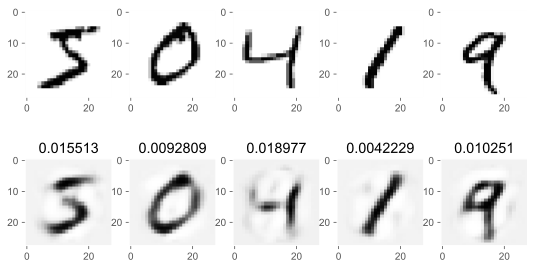

In [41]:
params = dict(bw=True, side_size=28, cmap='Greys')

pred_mnist = time_benchmark(mnist_model.predict, "predict train", X_mnist)
pred_t_mnist = time_benchmark(mnist_model.predict, "predict test", X_t_mnist)

print(f"train MSE: {MSE(X_mnist, pred_mnist)}")
print(f"test MSE: {MSE(X_t_mnist, pred_t_mnist)}")

plot_real_pred_images(X_mnist, pred_mnist, **params)
_ = plt.show()
plot_real_pred_images(X_t_mnist, pred_t_mnist, **params)

> Числа на выходе модели довольно хорошо различимы.

Возьмите несколько моделей из sklearn (KNN, SVM, RandomForest, GradientBoosting/XGBClassifier) и обучите модель со стандартными параметрами на выходах энкодера. Какие у вас получились результаты(точность) на тесте?

> Удаление верхнего слоя модели. Остается только энкодер.

In [42]:
mnist_model.pop()
mnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 30)                23550     
Total params: 23,550
Trainable params: 23,550
Non-trainable params: 0
_________________________________________________________________


> Кодирование данных с помощь. энкодера.

In [43]:
enc_mnist = time_benchmark(mnist_model.predict, "predict train", X_mnist)
enc_t_mnist = time_benchmark(mnist_model.predict, "predict_test", X_t_mnist)

print(enc_mnist.shape, enc_t_mnist.shape)

predict train time: 2.4150147438049316 sec.
predict_test time: 0.2536928653717041 sec.
(60000, 30) (10000, 30)


> К сожалению, из-за размерности 30 нет возможности визуализировать состояние выходов энкодера.

In [44]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, r2_score

In [45]:
models = (
    RandomForestClassifier(random_state=RANDOM_SEED),
    AdaBoostClassifier(random_state=RANDOM_SEED),
    GradientBoostingClassifier(random_state=RANDOM_SEED),
    KNeighborsClassifier(),
    SVC(random_state=RANDOM_SEED)
)

for model in models:
    m_name = model.__class__.__name__
    model = time_benchmark(model.fit, f"fit", enc_mnist, y_mnist)
    
    pred_train = time_benchmark(model.predict, f"pred train", enc_mnist)
    acc_train = accuracy_score(y_mnist, pred_train)
    r2_train = r2_score(y_mnist, pred_train)
    
    pred_test = time_benchmark(model.predict, f"pred test", enc_t_mnist)
    acc_t_train = accuracy_score(y_t_mnist, pred_test)
    r2_t_train = r2_score(y_t_mnist, pred_test)
    
    print(f"{m_name} train accuracy: {acc_train}, R2: {r2_train}")
    print(f"{m_name} test accuracy: {acc_t_train}, R2: {r2_t_train}")
    print()

fit time: 3.473497152328491 sec.
pred train time: 0.18752121925354004 sec.
pred test time: 0.04210662841796875 sec.
RandomForestClassifier train accuracy: 0.9988, R2: 0.9969412895609142
RandomForestClassifier test accuracy: 0.921, R2: 0.849687480905337

fit time: 15.107004642486572 sec.
pred train time: 1.1536898612976074 sec.
pred test time: 0.15868711471557617 sec.
AdaBoostClassifier train accuracy: 0.7148666666666667, R2: 0.4220574611536626
AdaBoostClassifier test accuracy: 0.7133, R2: 0.41665051796926056

fit time: 205.67691469192505 sec.
pred train time: 1.2616736888885498 sec.
pred test time: 0.18846940994262695 sec.
GradientBoostingClassifier train accuracy: 0.9384833333333333, R2: 0.8782784982837458
GradientBoostingClassifier test accuracy: 0.9242, R2: 0.8480655749550932

fit time: 0.18898439407348633 sec.
pred train time: 131.49763655662537 sec.
pred test time: 22.836315870285034 sec.
KNeighborsClassifier train accuracy: 0.98225, R2: 0.9625667349723116
KNeighborsClassifier tes

> Многие модели выдают довольно хорошие результаты. При этом нет моделей с $R^2 << 0.5$ на тесте.

### CIFAR10(2 балла)

Загрузите CIFAR10 и обучите автоэнкодер на случайных сэмплах размера 8x8 из этого датасета. Архитектура автоэнкодера как в прошлом пункте - только один внутренний слой из 30 нейронов.

In [46]:
from keras.datasets import cifar10

In [47]:
%%time

(X_cifar, y_cifar), (X_t_cifar, y_t_cifar) = cifar10.load_data()
y_cifar = y_cifar.reshape(-1)
y_t_cifar = y_t_cifar.reshape(-1)

print(X_cifar.shape, X_t_cifar.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
Wall time: 465 ms


> Визуализация нескольких изображений из набора.

In [48]:
plot_images_array(X_cifar, titles=y_cifar, side_size=32)

> Выбор случайных объектов 8х8.

In [49]:
%%time

cifar_samples = get_samples(X_cifar, num_samples=100000, sample_size=8)
cifar_t_samples = get_samples(X_t_cifar, num_samples=10000, sample_size=8)

print(cifar_samples.shape, cifar_t_samples.shape)

(100000, 8, 8, 3) (10000, 8, 8, 3)
Wall time: 1.36 s


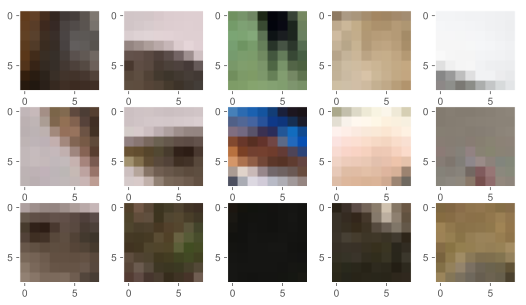

In [50]:
plot_images_array(cifar_samples)

> Трансформация в плоские вектора.

In [51]:
cifar_samples = cifar_samples.reshape(cifar_samples.shape[0], -1)
cifar_t_samples = cifar_t_samples.reshape(cifar_t_samples.shape[0], -1)
print(cifar_samples.shape, cifar_t_samples.shape)

(100000, 192) (10000, 192)


> Нормировка на отрезке [0.1, 0.9].

In [52]:
cifar_samples = MinMaxScaler((0.1, 0.9)).fit_transform(cifar_samples.astype('float32'))
cifar_t_samples = MinMaxScaler((0.1, 0.9)).fit_transform(cifar_t_samples.astype('float32'))

> Обучение модели автоэнкодера (добавлен параметр validation_data).

In [53]:
cifar_model = create_autoencoder_model(cifar_samples.shape[1], [30], [])
cifar_model.summary()

_ = time_benchmark(cifar_model.fit, "fit", cifar_samples, cifar_samples, verbose=0,
                   epochs=30, validation_data=(cifar_t_samples, cifar_t_samples))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 192)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 30)                5790      
_________________________________________________________________
dense_44 (Dense)             (None, 192)               5952      
Total params: 11,742
Trainable params: 11,742
Non-trainable params: 0
_________________________________________________________________
fit time: 126.74753022193909 sec.


predict train time: 2.2197489738464355 sec.
predict test time: 0.1562654972076416 sec.
train MSE: 0.0019571275915950537
test MSE: 0.002063939580693841


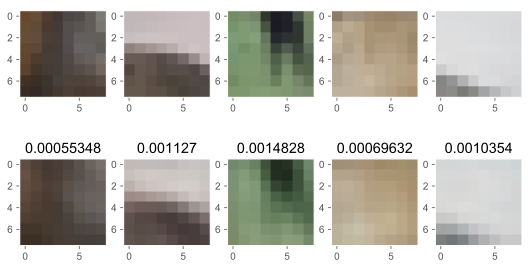

In [54]:
params = dict(side_size=8)

pred_cifar_samples = time_benchmark(cifar_model.predict, "predict train", cifar_samples)
pred_cifar_t_samples = time_benchmark(cifar_model.predict, "predict test", cifar_t_samples)

print(f"train MSE: {MSE(cifar_samples, pred_cifar_samples)}")
print(f"test MSE: {MSE(cifar_t_samples, pred_cifar_t_samples)}")

plot_real_pred_images(cifar_samples, pred_cifar_samples, **params)
_ = plt.show()
plot_real_pred_images(cifar_t_samples, pred_cifar_t_samples, **params)

Теперь разделите каждую картинку из датасета на 16 сэмплов размера 8x8, закодируйте их через энкодер и склейте 16 выходов энкодера в один вектор. Каждый объект в итоге должен кодироваться 16 * 30 = 480 признаками.

> Опять же, функция, возможно, не самая оптимальная, но выполняется приемлемо быстро.

In [55]:
def divide_into_parts(images: Collection,
                      parts: int=16) -> np.ndarray:
    """ Divide images into N similar parts. """
    side = images.shape[1]
    step = int(parts**(1/2))
    new_side = int(side // step)
    return np.array([
        [
            image[i:i+new_side, j:j+new_side, :] 
            for i in new_side*np.arange(step)
            for j in new_side*np.arange(step)
        ] for image in images
    ])

> Деление изображения на 16 частей 8х8.

In [56]:
%%time

X_cifar = divide_into_parts(X_cifar)
X_t_cifar = divide_into_parts(X_t_cifar)

print(X_cifar.shape, X_t_cifar.shape)

(50000, 16, 8, 8, 3) (10000, 16, 8, 8, 3)
Wall time: 2.77 s


> Для выполнения нормировки выполняется преобразование всех частей в плоские векторы.

In [57]:
X_cifar = X_cifar.reshape(X_cifar.shape[0], -1)
X_t_cifar = X_t_cifar.reshape(X_t_cifar.shape[0], -1)

print(X_cifar.shape, X_t_cifar.shape)

(50000, 3072) (10000, 3072)


> Нормировка.

In [58]:
X_cifar = MinMaxScaler((0.1, 0.9)).fit_transform(X_cifar.astype('float32'))
X_t_cifar = MinMaxScaler((0.1, 0.9)).fit_transform(X_t_cifar.astype('float32'))

> Обратное преобразование в набор изображений.

In [59]:
X_cifar = X_cifar.reshape(X_cifar.shape[0], 16, -1)
X_t_cifar = X_t_cifar.reshape(X_t_cifar.shape[0], 16, -1)

print(X_cifar.shape, X_t_cifar.shape)

(50000, 16, 192) (10000, 16, 192)


> Демонстрация правильности разбиения.

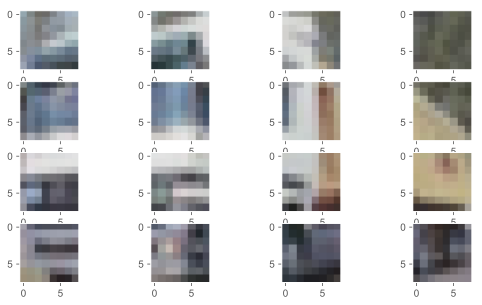

In [60]:
plot_images_array(X_cifar[1], shape=(4, 4), side_size=8)

> Удаление верхнего слоя модели.

In [61]:
cifar_model.pop()
cifar_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 192)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 30)                5790      
Total params: 5,790
Trainable params: 5,790
Non-trainable params: 0
_________________________________________________________________


> Получение описания объектов через 480 признаков.

In [62]:
%%time

enc_cifar = np.array([cifar_model.predict(image).reshape(-1) 
                      for image in X_cifar])
enc_t_cifar = np.array([cifar_model.predict(image).reshape(-1) 
                        for image in X_t_cifar])

print(enc_cifar.shape, enc_t_cifar.shape)

(50000, 480) (10000, 480)
Wall time: 24.8 s


Теперь обучите SVM на преобразованных объектах и выведите точность.

> Также рассмотрены и другие классификаторы, в том числе RandomForestClassifier, поскольку его обучение происходит быстрее. Подбор параметров моделей не осуществляется.

In [63]:
models = (
    RandomForestClassifier(random_state=RANDOM_SEED),
    AdaBoostClassifier(random_state=RANDOM_SEED),
    GradientBoostingClassifier(random_state=RANDOM_SEED),
    KNeighborsClassifier(),
    SVC(random_state=RANDOM_SEED)
)

for model in models:
    m_name = model.__class__.__name__
    model = time_benchmark(model.fit, "fit", enc_cifar, y_cifar)

    pred_cifar = time_benchmark(model.predict, "predict train", enc_cifar)
    acc_train = accuracy_score(y_cifar, pred_cifar)
    r2_train = r2_score(y_cifar, pred_cifar)

    pred_t_cifar = time_benchmark(model.predict, "predict test", enc_t_cifar)
    acc_t_train = accuracy_score(y_t_cifar, pred_t_cifar)
    r2_t_train = r2_score(y_t_cifar, pred_t_cifar)

    print(f"{m_name} train accuracy: {acc_train}, R2: {r2_train}")
    print(f"{m_name} test accuracy: {acc_t_train}, R2: {r2_t_train}")
    print()

fit time: 9.86313533782959 sec.
predict train time: 0.2606949806213379 sec.
predict test time: 0.05909466743469238 sec.
RandomForestClassifier train accuracy: 0.99368, R2: 0.9860945454545454
RandomForestClassifier test accuracy: 0.3301, R2: -0.539260606060606

fit time: 148.3346025943756 sec.
predict train time: 1.6671674251556396 sec.
predict test time: 0.3234212398529053 sec.
AdaBoostClassifier train accuracy: 0.31636, R2: -0.6978254545454545
AdaBoostClassifier test accuracy: 0.3141, R2: -0.7137090909090908

fit time: 2290.026363134384 sec.
predict train time: 3.24080753326416 sec.
predict test time: 0.6158127784729004 sec.
GradientBoostingClassifier train accuracy: 0.55606, R2: -0.02591030303030295
GradientBoostingClassifier test accuracy: 0.4646, R2: -0.22939393939393948

fit time: 2.3848936557769775 sec.
predict train time: 2311.4088037014008 sec.
predict test time: 464.8294072151184 sec.
KNeighborsClassifier train accuracy: 0.49504, R2: -0.07971878787878794
KNeighborsClassifier t

> Без подбора параметров получается низкое качество предсказаний модели. $R^2 < 0$ на тесте, следовательно модели классифицируют данные хуже, чем случайный выбор ответов.